In [70]:
#Includes necesarios
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split

from auxiliar import get_train_set,get_holdout_set,create_prediction
import preprocessing as pr

from auxiliar import plot_cm,plot_tree
from sklearn.metrics import classification_report,plot_roc_curve

# **Regresión Logistica**

Los hiperparametros que consideramos relevantes para el modelo Regresion Logistica son:
   - penalty: El metodo de regularizacion que se aplica. Puede ser l1,l2,elasticnet o ninguna, dependiendo el solver.
   - C: Inversa de la fuerza de regularización, debe ser numero positivo. Valores más pequeños especifican una regularización más fuerte.
   - solver: Algoritmo para utilizar en la optimizacion
   - l1_ratio: parametro para el metodo Elasticnet que resulta combinar L1 y L2.

Obtenemos el dataset con el cual entrenaremos nuestro modelo. Para este modelo se opto unicamente tratar los missings como categoricos:

In [71]:
X,y = get_train_set()
X = pr.init_dataset(X)

## Preprocesamiento 1: OHE

Primero vamos a entrenar nuestra regresion logisitca aplicando unicamente OHE a las columnas categoricas. Vamos a aplicar distintos tipos de *solver* apropiados para dataset que no tienen algun tipo de escalado en sus features:

In [72]:
pr.init_OHE(X)
X_ohe = pr.apply_OHE(X)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [73]:
X_train, X_validation, y_train, y_validation = train_test_split(X_ohe,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para la regresion logistica con GridSearchCV.

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - Los metodos de regularizacion son aquellos compatibles con los solvers
    - Los distintos tipos de solver son apropiado para dataset que no tienen algun tipo de escalado en sus features
    
 Ahora bien, como nuestro dataset tiene una larga cantidad de muestras, es de esperar que la busqueda de hiperparametros sea extensa en tiempo. La busqueda tarda aproximadamente 10 minutos con el parametro *n_jobs = -1*.

In [74]:
parameters = {
    'penalty': ['l2','none'],
    'C': np.arange(0.1, 1.1, 0.1),
    'solver': ['newton-cg', 'lbfgs']
    
}

clf = LogisticRegression(random_state=0)

gscv = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv.score(X_validation, y_validation)}")

Best score: 0.9022991234131137
Best params {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
------------------
Score in Validation: 0.8926194517240668


Aramamos el modelo de regresion logistica con los hiperparametros calculados:

In [75]:
model_logreg = gscv.best_estimator_
model_logreg

LogisticRegression(random_state=0, solver='newton-cg')

Predecimos con el validation set:

In [76]:
logreg_predict = model_logreg.predict(X_validation)

**Metricas**

In [77]:
print(classification_report(y_validation, logreg_predict))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      4945
           1       0.71      0.57      0.63      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.75      0.77      6513
weighted avg       0.83      0.84      0.83      6513



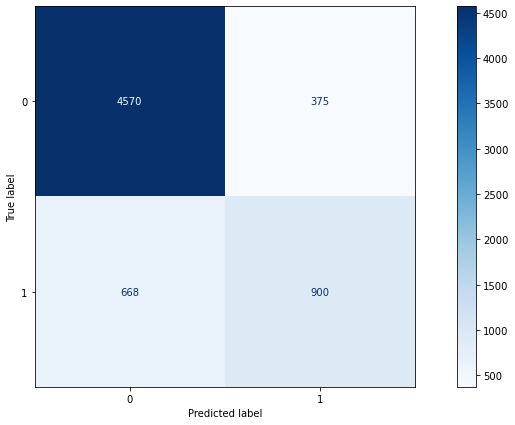

In [78]:
plot_cm(model_logreg, X_validation, y_validation)

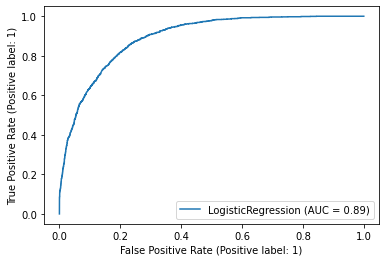

In [79]:
plot_roc_curve(model_logreg, X_validation, y_validation, response_method="predict_proba")
plt.show()

## Preprocesamiento 1: OHE + Escalado

Ahora luego de haber aplicado OHE, realizaremos un escalado de nuestras columnas con MinMaxScaler.Este ultimo paso sera util ya que utilizaremos distintos tipos de *solver* apropiados para largos dataset. El rango del escalado sera (0,1) que viene predeterminado:

In [80]:
X_scale = pr.scale(X_ohe)

Partimos nuestro set en *train* y *validation*, dejaremos un 20% de los datos para validación de nuestro entrenamiento:

In [81]:
X_train, X_validation, y_train, y_validation = train_test_split(X_scale,y, test_size=0.2, stratify=y, random_state=0)

Buscamos los mejores hiperparametros para la regresion logistica con GridSearchCV.

    - La métrica que se utiliza para comparar los modelos obtenidos en cada iteracion es roc_auc_score.
    - Los distintos tipos de solver son apropiado para dataset largos 

Empezamos con el solver *sag* el cual soporta el metodo de regularizacion L2

In [82]:
parameters = {
    'penalty': ['l2'],
    'C': np.arange(0.1, 1.1, 0.1),
    'solver': ['sag'] 
}

clf = LogisticRegression(random_state=0)

gscv1 = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv1.best_score_}")
print(f"Best params {gscv1.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv1.score(X_validation, y_validation)}")

Best score: 0.9003493295552781
Best params {'C': 1.0, 'penalty': 'l2', 'solver': 'sag'}
------------------
Score in Validation: 0.8922116495738843


El solver *saga* (una mejora del *sag*) soporta el metodo de regularizacion Elasticnet. Usaremos este metodo en combinacion con el hiperparametro *l1_ratio* para utilizar L1, L2 o bien la combinacion de ambos.

In [83]:
parameters = {
    'penalty': ['elasticnet'],
    'l1_ratio': np.arange(0, 1.1, 0.1),
    'C': np.arange(0.1, 1.1, 0.1),
    'solver': ['saga']
}

clf = LogisticRegression(random_state=0)

gscv2 = GridSearchCV(
    clf, parameters, scoring='roc_auc',n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv2.best_score_}")
print(f"Best params {gscv2.best_params_}")
print("------------------")
print(f"Score in Validation: {gscv2.score(X_validation, y_validation)}")

Best score: 0.9021914474866077
Best params {'C': 1.0, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}
------------------
Score in Validation: 0.8929257547306081


Vemos que el solver *saga* obtiene un mejor resultado de la metrica *auc_roc* pero esta diferencia no es muy relevante. Aramamos el modelo de regresion logistica con los hiperparametros calculados:

In [84]:
model_logreg_p1 = gscv2.best_estimator_
model_logreg_p1

LogisticRegression(l1_ratio=1.0, penalty='elasticnet', random_state=0,
                   solver='saga')

Predecimos con el validation set:

In [85]:
logreg_predict = model_logreg_p1.predict(X_validation)

**Metricas**

In [86]:
print(classification_report(y_validation, logreg_predict))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90      4945
           1       0.71      0.57      0.63      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.75      0.76      6513
weighted avg       0.83      0.84      0.83      6513



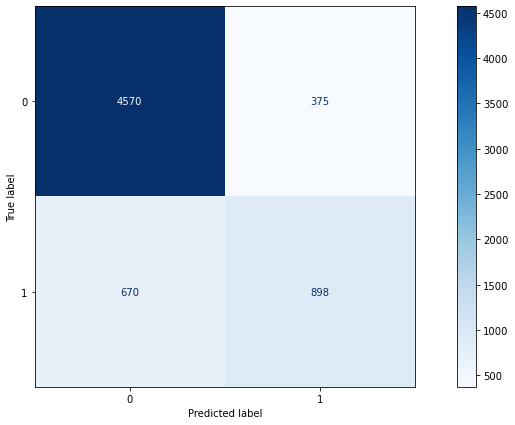

In [87]:
plot_cm(model_logreg_p1, X_validation, y_validation)

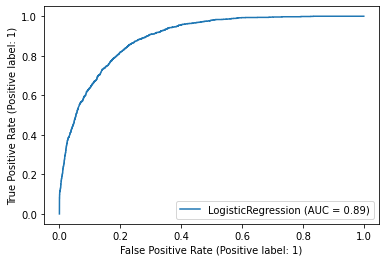

In [88]:
plot_roc_curve(model_logreg_p1, X_validation, y_validation, response_method="predict_proba")
plt.show()

# Conclusión

Vimos que no hay diferencia en los resultados de la metrica *auc_roc* utilizando distintos tipos de solver. El mejor resultado de *auc_roc* se obtiene realizando un escalado a las columnas y utilizando *saga*. De todas maneras, sklearn nos recomienda utilizar los solver *sag* o *saga* puesto que son optimizados para dataset largos como el nuestro.

# Predicción

Por ultimo, con nuestro mejor modelo obtenido realizaremos una prediccion para datos que nunca vio en el entrenamiento ni en validación.

In [89]:
ids, X_holdout = get_holdout_set()
X_holdout = pr.init_dataset(X_holdout)

In [90]:
pr.init_OHE(X)
X_holdout_ohe = pr.apply_OHE(X_holdout)
X_holdout_scale = pr.scale(X_holdout_ohe)

In [91]:
logreg_predict = model_logreg_p1.predict(X_holdout_scale)

In [92]:
create_prediction(ids,logreg_predict,file_name='regresion_logistica')